In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/project_Yuming/codes')

Mounted at /content/drive


In [ ]:
%%capture
!pip install ipython-autotime
!pip install torchdiffeq
!sudo apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng
!pip install latex
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super
%load_ext autotime
%matplotlib inline

time: 3.05 ms (started: 2021-06-07 09:28:53 +00:00)


In [ ]:
import utils
from core_training import train_loop_diff, train_loop_em_new
from viz_loss import loss_grad_vis_1d, loss_grad_vis_2d
# from tqdm import tqdm
from tqdm.auto import tqdm

from models import DEModel, DAModel, NNModel, Noise

# reflect real-time changes in other modules
import importlib
importlib.reload(utils)
importlib.reload(DEModel)
importlib.reload(DAModel)
importlib.reload(NNModel)
importlib.reload(Noise)

from utils import Timer
import copy
import math
import random
import torch
import torch.nn as nn
import numpy as np
from scipy.integrate import solve_ivp
from torchdiffeq import odeint_adjoint
from torchdiffeq import odeint

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rc

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device="cpu"
print(f"device: {device}")

device: cpu
time: 7.05 s (started: 2021-06-07 09:28:53 +00:00)


#2. NN

In [14]:
importlib.reload(sys.modules['core_training'])
importlib.reload(NNModel)
importlib.reload(Noise)
importlib.reload(utils)
importlib.reload(DAModel)
from core_training import train_loop_diff, train_loop_em_new


seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

x_dim = 3
true_coeff = torch.tensor([10., 8/3, 28.])
true_ode_func = NNModel.Lorenz63(true_coeff, x_dim)

init_m = torch.zeros(x_dim, device=device)
init_C_param = Noise.AddGaussian(x_dim, torch.tensor(10.), 'scalar')

train_and_test = 12
train_size = 8
with torch.no_grad():
  u0_warmup = torch.distributions.MultivariateNormal(torch.zeros(x_dim, device=device), covariance_matrix=100 * torch.eye(x_dim, device=device)).sample().to(device) # <-
  t_warmup = torch.cat((torch.tensor([0.]), 60*torch.arange(1, train_and_test+1))).to(device)
  out_warmup = odeint(true_ode_func, u0_warmup, t_warmup, method='rk4', options=dict(step_size=0.05))
  u0 = out_warmup[1:]  # (*bs, x_dim)

with torch.no_grad():
  u0_warmup = torch.distributions.MultivariateNormal(torch.zeros(x_dim, device=device), covariance_matrix=100 * torch.eye(x_dim, device=device)).sample((100,)).to(device) # <-
  t_warmup = torch.cat((torch.tensor([0.]), torch.arange(80.,880.,20.))).to(device)
  out_warmup = odeint(true_ode_func, u0_warmup, t_warmup, method='rk4', options=dict(step_size=0.05))
  u0_test = out_warmup[1:].reshape(-1,x_dim)  # (*bs, x_dim)
  print(u0_test.shape)

t0 = 0.
t_obs_step = 0.2
t_obs_end = 240.
t_obs = torch.arange(t0, t_obs_end+t_obs_step, t_obs_step)[1:].to(device)

model_Q_true = Noise.AddGaussian(x_dim, torch.tensor(math.sqrt(0.5)), param_type='scalar')

indices = [0,1,2]
y_dim = len(indices)
H_true = torch.eye(x_dim)[indices]
true_obs_func = NNModel.Linear(x_dim, y_dim, H=H_true).to(device)

noise_R_true = Noise.AddGaussian(y_dim, torch.tensor(math.sqrt(2)), param_type='scalar')

with torch.no_grad():
  out, y_obs, out_intermediate, t_intermediate = DEModel.generate_data(true_ode_func, true_obs_func, t_obs, u0, model_Q_true, noise_R_true, 
                                                device=device, ode_method='rk4', ode_options=dict(step_size=0.05), adjoint=False, save_intermediate_step=True, t0=0., time_varying_obs=False)

enkf_kwargs = dict(ode_method='rk4', ode_options=dict(step_size=0.05), adjoint=True, adjoint_method='rk4', adjoint_options=dict(step_size=0.05),save_intermediate_step=True, smooth_lag=0,
          var_inflation=None, localization_radius=None, compute_likelihood=True, likelihood_warmup=0, 
          linear_obs=True, time_varying_obs=False, save_first=True, simulation_type=0)

def monitor(ode_func, model_Q_param, noise_R_param, neg_log_likelihood, test_neg_log_likelihood, test_mse, one_step_fs, nll_suro_em, algorithm, device):
  res = torch.zeros(0, device=device)
  # res = torch.cat((res, ode_func.coeff.detach().clone().view(-1)))
  # res = torch.cat((res, model_Q_param.full().detach().clone().view(-1)))
  res = torch.cat((res, torch.sqrt(torch.diagonal(model_Q_param.full(u0_test), dim1=-2, dim2=-1).mean()).detach().clone().view(-1)))
  # res = torch.cat((res, noise_R_param.q_true().detach().clone().view(-1)))
  res = torch.cat((res, neg_log_likelihood.mean().detach().clone().view(-1)))
  res = torch.cat((res, test_neg_log_likelihood.mean().detach().clone().view(-1)))
  res = torch.cat((res, test_mse.detach().clone().view(-1)))
  res = torch.cat((res, one_step_fs.detach().clone().view(-1)))
  # if algorithm == "em":
  #   res = torch.cat((res, nll_suro_em.mean().detach().clone().view(-1)))
  return res.unsqueeze(dim=0)


Q_list = 2 * torch.ones(1, 3)
N_ensem = 25

save = True
save_location = f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz63/"
prefix = f"N_{N_ensem}_NN_diag_share_3_"

seed = 46
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


# enkf_kwargs['likelihood_warmup']=20
# monitor_EnKF = torch.zeros(0, device=device)
# for iter in range(3):#iter in range(1): 
#   # learned_ode_func = NNModel.ODE_Net(3, [3, 64,64, 3]).to(device)
#   # learned_model_Q = Noise.AddGaussian(x_dim, Q_list[0].detach().clone()*torch.eye(x_dim), 'tril').to(device)  # decay = 0.95
#   # # learned_model_Q = Noise.AddGaussianNet(x_dim, [3, 80, 9], 'tril').to(device) # decay = 0.9
#   # optimizer = torch.optim.Adam([{'params':learned_ode_func.parameters(), 'lr':1e-2},
#   #                            {'params':learned_model_Q.parameters(), 'lr':1e-1}])
  
#   base_net = NNModel.FC_Net(3, [3, 64, 64]).to(device)
#   learned_ode_func = NNModel.ODE_Net_from_basenet(base_net, [64,3])
#   learned_model_Q = Noise.AddGaussianNet_from_basenet(3, base_net, [64,3], 'diag').to(device) # decay = 0.98
#   optimizer = torch.optim.Adam([{'params':base_net.parameters(), 'lr':1e-2}, {'params':learned_ode_func.layers.parameters(), 'lr':1e-2}, {'params':learned_model_Q.layers.parameters(), 'lr':1e-2}])

#   # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.3)
#   scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.95)
#   # lda = lambda epoch: 0.95 if epoch >= 10 else 1
#   # scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=[lda, lda, lda])
#   monitor_res = train_loop_diff(learned_ode_func, true_obs_func, t_obs, y_obs, out, out_intermediate, N_ensem, init_m, init_C_param, learned_model_Q, noise_R_true, device, optimizer,proposal='optimal', adaptive_resampling=False, detach_every=None, n_epochs=101, 
#                                 scheduler=scheduler, batch_length=30, bs=1, print_every_n_epochs=5, test_every_n_epochs=1, test_filter=True, tbptt=3, method='enkf', train_size=train_size, clip_norm=None, 
#                                 true_system="L63", true_ode_func=true_ode_func, u0_test=u0_test, monitor=monitor, timer=True, lr_decay=None,**enkf_kwargs)
#   monitor_EnKF = torch.cat((monitor_EnKF, monitor_res.unsqueeze(0)))
# if save:
#   torch.save({'monitor': monitor_EnKF, 'learned_ode_func':learned_ode_func.state_dict(), 'learned_model_Q':learned_model_Q.state_dict()},save_location+prefix+"EnKF")

# enkf_kwargs['likelihood_warmup']=20
# monitor_EM = torch.zeros(0, device=device)
# for iter in range(3):
#   # learned_ode_func = NNModel.ODE_Net(3, [3, 64, 64, 3]).to(device)
#   # # learned_model_Q = Noise.AddGaussianNet(x_dim, [3, 80, 9], 'tril').to(device) # decay = 0.9
#   # learned_model_Q = Noise.AddGaussian(x_dim, Q_list[0].detach().clone()*torch.eye(x_dim), 'tril').to(device)  # decay = 0.95
#   # optimizer = torch.optim.Adam([{'params':learned_ode_func.parameters(), 'lr':1e-2}])
#   #                           #  {'params':learned_model_Q.parameters(), 'lr':1e-2}])

#   base_net = NNModel.FC_Net(3, [3, 64, 64]).to(device)
#   learned_ode_func = NNModel.ODE_Net_from_basenet(base_net, [64,3])
#   learned_model_Q = Noise.AddGaussianNet_from_basenet(3, base_net, [64,3], 'diag').to(device) # decay = 0.98
#   optimizer = torch.optim.Adam([{'params':base_net.parameters(), 'lr':1e-2}, {'params':learned_ode_func.layers.parameters(), 'lr':1e-2}, {'params':learned_model_Q.layers.parameters(), 'lr':1e-2}])

#   scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.95)
#   # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.3)
#   monitor_res, _ = train_loop_em_new(learned_ode_func, true_obs_func, t_obs, y_obs, out, out_intermediate, N_ensem, init_m, init_C_param, learned_model_Q, noise_R_true, device, optimizer, n_epochs=101, 
#                               scheduler=scheduler, batch_length=60, bs=1, print_every_n_epochs=5, test_every_n_epochs=1,test_filter=True, train_size=train_size, m_step_type="mean", m_steps=3,
#                               track_Q=None, true_system="L63", true_ode_func=true_ode_func, u0_test=u0_test, monitor=monitor, timer=True, lr_decay=None,**enkf_kwargs)
#   monitor_EM = torch.cat((monitor_EM, monitor_res.unsqueeze(0)))
# if save:
#   torch.save({'monitor': monitor_EM, 'learned_ode_func':learned_ode_func.state_dict(), 'learned_model_Q':learned_model_Q.state_dict()},save_location+prefix+"EM")

enkf_kwargs['likelihood_warmup']=20
monitor_PF = torch.zeros(0, device=device)
for iter in range(3):#iter in range(1): 
  # learned_ode_func = NNModel.ODE_Net(3, [3, 64,64, 3]).to(device)
  # learned_model_Q = Noise.AddGaussian(x_dim, Q_list[0].detach().clone()*torch.eye(x_dim), 'tril').to(device)  # decay = 0.95
  # # learned_model_Q = Noise.AddGaussianNet(x_dim, [3, 80, 9], 'tril').to(device) # decay = 0.9
  # optimizer = torch.optim.Adam([{'params':learned_ode_func.parameters(), 'lr':1e-2},
  #                            {'params':learned_model_Q.parameters(), 'lr':1e-1}])

  base_net = NNModel.FC_Net(3, [3, 64, 64]).to(device)
  learned_ode_func = NNModel.ODE_Net_from_basenet(base_net, [64,3])
  learned_model_Q = Noise.AddGaussianNet_from_basenet(3, base_net, [64,3], 'diag').to(device) # decay = 0.98
  optimizer = torch.optim.Adam([{'params':base_net.parameters(), 'lr':1e-2}, {'params':learned_ode_func.layers.parameters(), 'lr':1e-2}, {'params':learned_model_Q.layers.parameters(), 'lr':1e-2}])


  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.95)
  # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.3)
  monitor_res = train_loop_diff(learned_ode_func, true_obs_func, t_obs, y_obs, out, out_intermediate, N_ensem, init_m, init_C_param, learned_model_Q, noise_R_true, device, optimizer,proposal='optimal', adaptive_resampling=False, n_epochs=101, 
                                scheduler=scheduler, batch_length=30, bs=1, print_every_n_epochs=5, test_every_n_epochs=1,test_filter=True, tbptt=6, method='pf', detach_every=None, train_size=train_size, clip_norm=None, 
                                true_system="L63", true_ode_func=true_ode_func, u0_test=u0_test, monitor=monitor, timer=True, lr_decay=None, **enkf_kwargs)
  monitor_PF = torch.cat((monitor_PF, monitor_res.unsqueeze(0)))
if save:
  torch.save({'monitor': monitor_PF, 'learned_ode_func':learned_ode_func.state_dict(), 'learned_model_Q':learned_model_Q.state_dict()},save_location+prefix+"PF")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
PF:1.6, LAG3
EnKF:1.55, LAG3
PF:1.94, LAG6

In [ ]:
d_EnKF = torch.load(f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz63/N_25_NN_diag_share_EnKF")
monitor_EnKF = d_EnKF['monitor']
d_EM = torch.load(f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz63/N_25_NN_diag_share_EM")
monitor_EM = d_EM['monitor']
d_PF = torch.load(f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz63/N_25_NN_diag_share2_PF")
monitor_PF = d_PF['monitor']

time: 1.38 s (started: 2021-05-31 03:59:08 +00:00)


In [7]:
monitor_EnKF[:,-1,:]

tensor([[ 7.3320e-01, -7.6155e+03, -7.5345e+03,  7.9643e-01,  9.7739e-01,
          9.6151e-01,  9.1544e-01,  1.5548e-01,  2.2388e-01,  2.9614e-01,
          1.0107e+00],
        [ 7.3733e-01, -7.6160e+03, -7.5284e+03,  7.9962e-01,  9.7225e-01,
          9.5519e-01,  9.1233e-01,  1.6416e-01,  2.3063e-01,  2.9288e-01,
          9.5607e-01],
        [ 7.3309e-01, -7.6216e+03, -7.5404e+03,  8.0434e-01,  9.7299e-01,
          9.6285e-01,  9.1665e-01,  1.6424e-01,  2.3526e-01,  2.7222e-01,
          6.8855e-01]])

time: 16.2 ms (started: 2021-06-07 20:47:16 +00:00)


In [16]:
d_EnKF = torch.load(f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz63/N_25_NN_diag_share_3_EnKF")
monitor_EnKF = d_EnKF['monitor']
base_net = NNModel.FC_Net(3, [3, 64, 64]).to(device)
learned_ode_func = NNModel.ODE_Net_from_basenet(base_net, [64,3])
learned_model_Q = Noise.AddGaussianNet_from_basenet(3, base_net, [64,3], 'diag').to(device)
learned_ode_func.load_state_dict(d_EnKF['learned_ode_func'])
learned_model_Q.load_state_dict(d_EnKF['learned_model_Q'])

with torch.no_grad():
  _, X_track_test, _, test_neg_log_likelihood = DAModel.EnKF(learned_ode_func, true_obs_func, t_obs, y_obs[:,8:], 100, init_m, init_C_param, learned_model_Q, noise_R_true, device, **enkf_kwargs) 
  _, X_track_test2, _, test_neg_log_likelihood2 = DAModel.EnKF(true_ode_func, true_obs_func, t_obs, y_obs[:,8:], 100, init_m, init_C_param, model_Q_true, noise_R_true, device, **enkf_kwargs) 

print(torch.sqrt(utils.mse_loss(X_track_test.mean(dim=-2)[241:], out[240:,8:])))
print(torch.sqrt(utils.mse_loss(X_track_test2.mean(dim=-2)[241:], out[240:,8:])))
print(test_neg_log_likelihood.mean(), test_neg_log_likelihood2.mean())

tensor(0.9118)
tensor(0.8973)
tensor(-7528.2461) tensor(-7498.0894)
time: 16.1 s (started: 2021-06-08 04:19:14 +00:00)


In [17]:
d_EM = torch.load(f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz63/N_25_NN_diag_share_3_EM")
monitor_EM = d_EM['monitor']
base_net = NNModel.FC_Net(3, [3, 64, 64]).to(device)
learned_ode_func = NNModel.ODE_Net_from_basenet(base_net, [64,3])
learned_model_Q = Noise.AddGaussianNet_from_basenet(3, base_net, [64,3], 'diag').to(device)
learned_ode_func.load_state_dict(d_EM['learned_ode_func'])
learned_model_Q.load_state_dict(d_EM['learned_model_Q'])

with torch.no_grad():
  _, X_track_test, _, test_neg_log_likelihood = DAModel.EnKF(learned_ode_func, true_obs_func, t_obs, y_obs[:,8:], 100, init_m, init_C_param, learned_model_Q, noise_R_true, device, **enkf_kwargs) 
  _, X_track_test2, _, test_neg_log_likelihood2 = DAModel.EnKF(true_ode_func, true_obs_func, t_obs, y_obs[:,8:], 100, init_m, init_C_param, model_Q_true, noise_R_true, device, **enkf_kwargs) 

print(torch.sqrt(utils.mse_loss(X_track_test.mean(dim=-2)[1:], out[:,8:])))
print(torch.sqrt(utils.mse_loss(X_track_test2.mean(dim=-2)[1:], out[:,8:])))
print(test_neg_log_likelihood.mean(), test_neg_log_likelihood2.mean())

tensor(1.0307)
tensor(0.8956)
tensor(-7964.1406) tensor(-7502.8389)
time: 16 s (started: 2021-06-08 04:19:30 +00:00)


In [ ]:
print(monitor_EnKF[:,-1,:])

tensor([[ 6.4971e-01, -7.6321e+03, -7.5875e+03,  8.1361e-01,  9.3689e-01,
          9.6384e-01,  9.0714e-01,  2.1072e-01,  3.0093e-01,  3.0675e-01,
          6.7001e-01],
        [ 6.0457e-01, -7.6044e+03, -7.5957e+03,  8.2451e-01,  9.4098e-01,
          9.7722e-01,  9.1656e-01,  2.1973e-01,  3.2121e-01,  3.4490e-01,
          6.6566e-01],
        [ 6.3524e-01, -7.6305e+03, -7.5932e+03,  8.2453e-01,  9.3725e-01,
          9.6486e-01,  9.1091e-01,  2.3515e-01,  3.2475e-01,  3.4221e-01,
          8.8506e-01]])
time: 8.95 ms (started: 2021-06-05 19:34:49 +00:00)


In [18]:
d_PF = torch.load(f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz63/N_25_NN_diag_share_3_PF")
monitor_PF = d_PF['monitor']
base_net = NNModel.FC_Net(3, [3, 64, 64]).to(device)
learned_ode_func = NNModel.ODE_Net_from_basenet(base_net, [64,3])
learned_model_Q = Noise.AddGaussianNet_from_basenet(3, base_net, [64,3], 'diag').to(device)
learned_ode_func.load_state_dict(d_PF['learned_ode_func'])
learned_model_Q.load_state_dict(d_PF['learned_model_Q'])

with torch.no_grad():
  _, _, X_track_test1, _, w_track_test1, _, test_neg_log_likelihood1 = DAModel.BootstrapPF(learned_ode_func, true_obs_func, t_obs, y_obs[:,8:], 100, init_m, init_C_param, learned_model_Q, noise_R_true, device, 'optimal', False, **enkf_kwargs) 
  _, _, X_track_test3, _, w_track_test3, _, test_neg_log_likelihood3 = DAModel.BootstrapPF(true_ode_func, true_obs_func, t_obs, y_obs[:,8:], 10000, init_m, init_C_param, model_Q_true, noise_R_true, device, 'optimal', False, **enkf_kwargs) 

print(torch.sqrt(utils.particle_mse_loss(X_track_test1[1:], out[:,8:], w_track_test1[1:])))
print(torch.sqrt(utils.particle_mse_loss(X_track_test3[1:], out[:,8:], w_track_test3[1:])))
print(test_neg_log_likelihood1.mean(), test_neg_log_likelihood3.mean())

tensor(0.9273)
tensor(0.8640)
tensor(-7571.2114) tensor(-7430.1382)
time: 1min 15s (started: 2021-06-08 04:19:46 +00:00)


In [ ]:
utils.plot_filter(t_obs[:200], out[:200,0], X_track_test[1:201], name="Ensemble", plot_all=False, compare_F_S=False, fig_num_limit=None)

In [ ]:
print(monitor_EnKF.shape, monitor_EM.shape, monitor_PF.shape)

torch.Size([1, 102, 11]) torch.Size([1, 102, 11]) torch.Size([0])
time: 2.84 ms (started: 2021-06-07 09:01:24 +00:00)


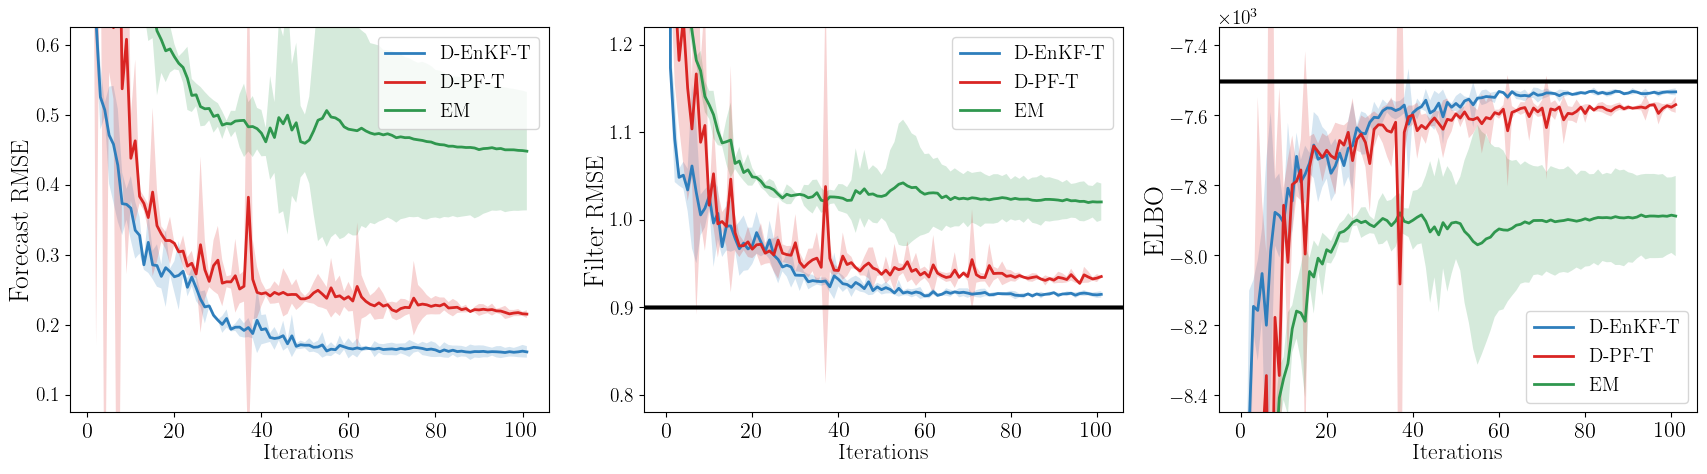

time: 2.21 s (started: 2021-06-08 04:33:31 +00:00)


In [27]:
importlib.reload(utils)

mpl.rc_file_defaults()
rc('font', **{'family':'serif','serif':'Computer Modern'})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
mpl.rcParams['axes.titlesize']= 18
# mpl.rcParams['axes.grid']= True
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.labelpad'] = 1
# mpl.rcParams['lines.linewidth'] = 10
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize']= 14
mpl.rcParams['legend.fontsize']= 14



def custom_axes(axes, ax_d):

  # axes[0,1].set_ylim(-9000,-8500)
  # axes[0,2].set_ylim(-9000,-8500)
  # axes[1,0].set_ylim(1,2)
  # axes[1,1].set_ylim(1,2)
  # axes[1,2].set_ylim(1,2)
  # axes[2,0].set_ylim(1,2)
  # axes[2,1].set_ylim(0,1)
  # axes[2,2].set_ylim(0,2)
  # axes[3,0].set_ylim(0,2)
  # axes[3,1].set_ylim(0,2)
  # axes[3,0].set_ylim(0.5,1.2)


  axes[0,0].set_xlabel(r"Iterations", fontsize=17)
  axes[0,0].set_ylabel(r"Forecast {\LARGE RMSE}")
  axes[0,1].set_xlabel(r"Iterations", fontsize=17)
  axes[0,1].set_ylabel(r"Filter {\LARGE RMSE}")
  axes[0,2].set_xlabel(r"Iterations", fontsize=17)
  axes[0,2].set_ylabel(r"ELBO")
  utils.set_lim_ticks(axes[0,0], 0.1, 0.6, 6)
  utils.set_lim_ticks(axes[0,1], 0.8, 1.2, 5)
  utils.set_lim_ticks(axes[0,2], -8400, -7400, 6)
  # axes[0,1].yaxis.set_ticks(np.arange(1.2, 2.1, 0.2))

  # axes[0,2].set_ylim(-8820,-7280)
  legend_order=[0,1,2]
  handles, labels = utils.unique_labels(axes[0,2])
  axes[0,2].legend([handles[idx] for idx in legend_order],[labels[idx] for idx in legend_order], loc='lower right')  
  axes[0,2].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
  return

# monitor_KF_truths=monitor_KF[0,-1,:]
monitor_EnKF_new=monitor_EnKF.detach().clone()
monitor_EM_new=monitor_EM.detach().clone()
monitor_PF_new=monitor_PF.detach().clone()

# with torch.no_grad():
#   _, X_track_test2, _, test_neg_log_likelihood2 = DAModel.EnKF(true_ode_func, true_obs_func, t_obs, y_obs[:,8:], 100, init_m, init_C_param, model_Q_true, noise_R_true, device, **enkf_kwargs) 
# rmsea = torch.sqrt(utils.mse_loss(X_track_test2.mean(dim=-2)[241:], out[240:,8:])).item()
# test_ELBO = test_neg_log_likelihood2.mean().item()


save_location=None
load_location=None
save_location = f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz63/learn"
torch.save({'rmsea':rmsea, 'test_ELBO':test_ELBO}, save_location+"_truth")
# load_location = f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Linear/param_est"

# monitor_res = [monitor_KF,monitor_EnKF, monitor_PF]
monitor_res = [monitor_EnKF_new,monitor_EM_new,monitor_PF_new]#,monitor_PF-monitor_KF]
methods = [ r"D-EnKF-T",r"EM",r"D-PF-T"]
# titles = ["Likelihood estimate", "grad"]
titles = [None] * 20
truths = [None] * 20
truths_legends = ['t','t',None,'t','t',None]
# truths2 = [None, monitor_KF_truths[1]**2, monitor_KF_truths[2]] + [None, monitor_KF_truths[4]**2, monitor_KF_truths[5]]
truths2 = [None] * 20
truths2[2], truths2[6] = test_ELBO, rmsea
truths2_legends = None

groups = None
plots_to_show = [7,6,2]
logscale={}#{0,1,2}
logscalex={}
legend_order=None
utils.plot_monitor_res_new(monitor_res, methods, titles, truths, logscale, logscalex, truths_legends=truths_legends, truths2=truths2, truths2_legends=truths2_legends,  start_from_one={0}, legend_order=legend_order, groups=groups,
                           error_bar=True, error_bar_style="std", n_cols=3,subplot_width=7, subplot_height=5,linewidth=2, plots_to_show=plots_to_show, x_axiss=None, custom_axes=custom_axes, save_location=save_location, load_location=load_location)